In [1]:
!pip install keras-tuner -q

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras as k

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.optimizers import SGD
from keras.regularizers import l2

from keras.utils.vis_utils import plot_model

from keras import layers
# from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

from keras.callbacks import ModelCheckpoint, CSVLogger


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.3 MB/s eta 0:00:00


In [2]:
## Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.chdir('/content/drive/MyDrive/SylviaCapstone/') # DATA_DIR = "/content/drive/MyDrive/SylviaCapstone"
!ls

 10_food_classes_10_percent	   Checkpoints.index
 10_food_classes_10_percent.zip   'Copy of W6-VGG16.ipynb'
 checkpoint			   FC_tuning_dir
 Checkpoints			   W6TuningTrial.ipynb
 Checkpoints.data-00000-of-00001


# Pre-processing

In [4]:
N_CLASS = 10
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [5]:
train_dir = "10_food_classes_10_percent/test/"
test_dir = "10_food_classes_10_percent/train/"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Training images:")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print("Testing images:")
validation_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 2500 images belonging to 10 classes.
Testing images:
Found 750 images belonging to 10 classes.


# Model Training


##Tuning

In [6]:
def create_model(hp):
    vgg16 = VGG16(weights='imagenet', include_top=False)

    for layer in vgg16.layers:
        layer.trainable = False

    x = vgg16.output
    x = layers.GlobalAveragePooling2D()(x)

    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        # Tune number of units in the dense layer (128,256,512) separately.
        units = hp.Choice("units",[512,1024,2048])
        x = layers.Dense(units, activation='relu') (x)

    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = layers.Dropout(dropout_rate)(x)

    predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = k.Model(inputs=vgg16.input, outputs=predictions)

    optimizer = SGD(lr=0.001, momentum=0.9)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# quickly test if the model builds successfully.
create_model(kt.HyperParameters())

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# Define the tuner
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=12, # 2/3 the combinations
    directory='FC_tuning_dir',  # Change this to your preferred directory
    project_name='vgg16_tuning-w6-new')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
# Start the hyperparameter search
tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=10,
             verbose=1,
             callbacks=[stop_early])

In [9]:

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the details of the best trial
print("Best Hyperparameters:")
print(best_hyperparameters.values)  # print the best combination of hyperparameters

Best Hyperparameters:
{'num_layers': 2, 'units': 2048, 'dropout_rate': 0.2}


In [ ]:
tuner.results_summary()

Results summary
Results in FC_tuning_dir/vgg16_tuning-w6-new
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_layers: 2
units: 2048
dropout_rate: 0.2
Score: 0.40933331847190857

Trial 11 summary
Hyperparameters:
num_layers: 1
units: 1024
dropout_rate: 0.4
Score: 0.4026666581630707

Trial 10 summary
Hyperparameters:
num_layers: 2
units: 2048
dropout_rate: 0.4
Score: 0.3986666798591614

Trial 02 summary
Hyperparameters:
num_layers: 1
units: 2048
dropout_rate: 0.4
Score: 0.3959999978542328

Trial 01 summary
Hyperparameters:
num_layers: 2
units: 1024
dropout_rate: 0.4
Score: 0.3946666717529297

Trial 00 summary
Hyperparameters:
num_layers: 1
units: 512
dropout_rate: 0.30000000000000004
Score: 0.390666663646698

Trial 07 summary
Hyperparameters:
num_layers: 2
units: 512
dropout_rate: 0.4
Score: 0.390666663646698

Trial 08 summary
Hyperparameters:
num_layers: 1
units: 1024
dropout_rate: 0.30000000000000004
Score: 0.390666663646698


### Train VGG16 with best architecture
Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [12]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='w6_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_list = [tl_checkpoint_1,stop_early]

# callbacks_list = [tf.keras.callbacks.ModelCheckpoint(
#         filepath = 'Checkpoints',
#         monitor = 'val_loss',
#         save_best_only = True,
#         save_weights_only=True), stop_early]

In [ ]:
# Train the best architecture model for 15 epochs
best_model = create_model(best_hyperparameters)
history = best_model.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-VGG16-FC')
plot_loss(history,'FOOD101-VGG16-FC')

## Un-freeze the last few pre-trained layers.

Unfreeze the last 4 layers

In [17]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-4]:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
79/79 [==============================] - ETA: 0s - loss: 2.3566 - accuracy: 0.1744
Epoch 1: val_loss did not improve from 1.48212
79/79 [==============================] - 56s 677ms/step - loss: 2.3566 - accuracy: 0.1744 - val_loss: 2.2316 - val_accuracy: 0.2560
Epoch 2/15
79/79 [==============================] - ETA: 0s - loss: 2.0137 - accuracy: 0.3292
Epoch 2: val_loss did not improve from 1.48212
79/79 [==============================] - 46s 584ms/step - loss: 2.0137 - accuracy: 0.3292 - val_loss: 1.8752 - val_accuracy: 0.3467
Epoch 3/15
79/79 [==============================] - ETA: 0s - loss: 1.6392 - accuracy: 0.4436
Epoch 3: val_loss did not improve from 1.48212
79/79 [==============================] - 43s 547ms/step - loss: 1.6392 - accuracy: 0.4436 - val_loss: 1.6243 - val_accuracy: 0.4787
Epoch 4/15
79/79 [==============================] - ETA: 0s - loss: 1.4467 - accuracy: 0.5368
Epoch 4: val_loss did not improve from 1.48212
79/79 [==============================] -

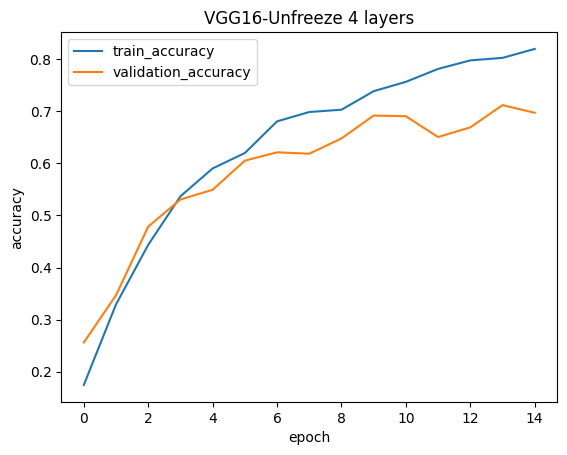

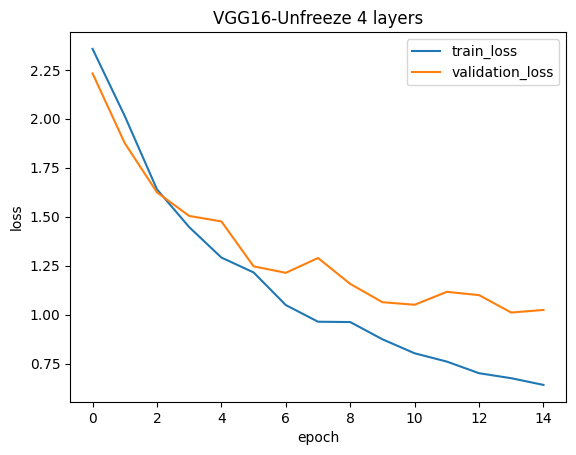

In [18]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'VGG16-Unfreeze 4 layers')
plot_loss(history,'VGG16-Unfreeze 4 layers')

Unfreeze the last 8 layers

In [19]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='w6_model_v2.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_list_2 = [tl_checkpoint_1,stop_early]

In [20]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-8]:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model2 = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)

model2.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = model2.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list_2)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
79/79 [==============================] - ETA: 0s - loss: 2.2700 - accuracy: 0.2068
Epoch 1: val_loss did not improve from 1.01045
79/79 [==============================] - 48s 564ms/step - loss: 2.2700 - accuracy: 0.2068 - val_loss: 2.0021 - val_accuracy: 0.3600
Epoch 2/15
79/79 [==============================] - ETA: 0s - loss: 1.7687 - accuracy: 0.4168
Epoch 2: val_loss did not improve from 1.01045
79/79 [==============================] - 45s 574ms/step - loss: 1.7687 - accuracy: 0.4168 - val_loss: 1.7864 - val_accuracy: 0.4107
Epoch 3/15
79/79 [==============================] - ETA: 0s - loss: 1.4126 - accuracy: 0.5588
Epoch 3: val_loss did not improve from 1.01045
79/79 [==============================] - 45s 575ms/step - loss: 1.4126 - accuracy: 0.5588 - val_loss: 1.3434 - val_accuracy: 0.5893
Epoch 4/15
79/79 [==============================] - ETA: 0s - loss: 1.2289 - accuracy: 0.6156
Epoch 4: val_loss did not improve from 1.01045
79/79 [==============================] -

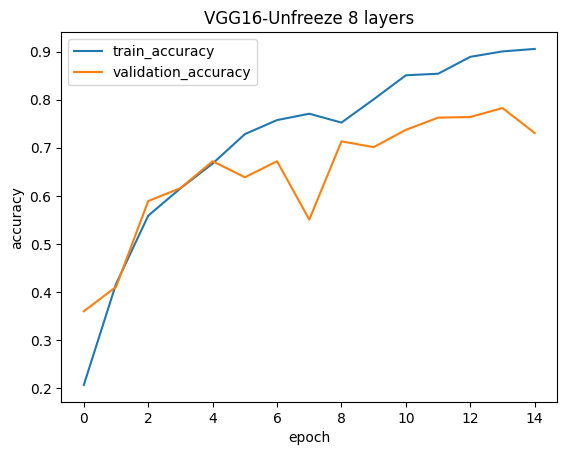

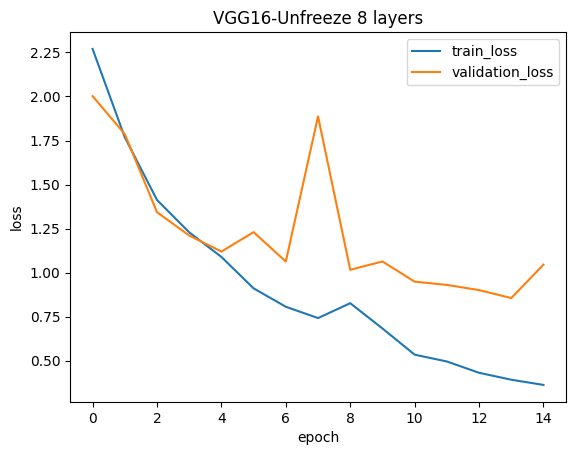

In [22]:
plot_accuracy(history2,'VGG16-Unfreeze 8 layers')
plot_loss(history2,'VGG16-Unfreeze 8 layers')